In [1]:
import os
from zipfile import BadZipFile, ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs

In [ ]:
# boundary data
ie = gpd.read_file(
    os.path.join("..", "ClimAg", "ClimAg", "data", "boundaries", "boundaries.gpkg"),
    layer="NUTS_RG_01M_2021_2157_IE"
)

In [2]:
ZIP_FILE = os.path.join("data", "Kish-Basin-dat-files.zip")
DATA_DIR = os.path.join("data", "kish-basin")

In [3]:
ZipFile(ZIP_FILE).namelist()

['Flyde Halite Base Depth XYZ Meters.dat',
 'Flyde Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Flyde Halite Thickness XYZ Meters.dat',
 'Flyde Halite Top Depth XYZ Meters.dat',
 'Flyde Halite Top TWT XYZ Milliseconds.dat',
 'Kish GIS Map Extent - Square.csv',
 'Mythop Halite Base Depth XYZ Meters.dat',
 'Mythop Halite Thickness XYZ Meters.dat',
 'Mythop Halite Top Depth XYZ Meters.dat',
 'Mythop Halite Top TWT XYZ Milliseconds.dat',
 'Presall Halite Base Depth XYZ Meters-corrected.dat',
 'Presall Halite Thickness - Zone Of Interest - XYZ Meters-corrected.dat',
 'Presall Halite Thickness XYZ Meters-corrected.dat',
 'Presall Halite Top Depth XYZ Meters-corrected.dat',
 'Presall Halite Top TWT XYZ Milliseconds.dat',
 'Rossall Halite Base Depth XYZ Meters.dat',
 'Rossall Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Rossall Halite Thickness XYZ Meters.dat',
 'Rossall Halite Top Depth XYZ Meters.dat',
 'Rossall Halite Top TWT XYZ Milliseconds.dat']

In [4]:
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [5]:
with open(os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv")) as f:
    print(f.read())

Polygon exported from Kingdom on Thu Nov  3 20:00:33 2022
Coordinate System: ED50 / UTM zone 29N   EPSG: 23029
Polygon Name, Index, X, Y
AREA OF INTEREST,1,742000.000000,5937000.000000
AREA OF INTEREST,2,687000.000000,5937000.000000
AREA OF INTEREST,3,687000.000000,5888000.000000
AREA OF INTEREST,4,742000.000000,5888000.000000
AREA OF INTEREST,5,742000.000000,5937000.000000



### Flyde Halite Base Depth XYZ Meters

In [6]:
f_base_depth_m = pd.read_fwf(os.path.join(DATA_DIR, "Flyde Halite Base Depth XYZ Meters.dat"), header=None, names=["X", "Y", "Z"])

In [7]:
f_base_depth_m["wkt"] = (
    "POINT (" + f_base_depth_m["X"].astype(str) + " " +
    f_base_depth_m["Y"].astype(str) + " " +
    f_base_depth_m["Z"].astype(str) + ")"
)

In [8]:
f_base_depth_m.head()

,X,Y,Z,wkt
0,696600.0,5903800.0,2318.0615,POINT (696600.0 5903800.0 2318.0615)
1,696800.0,5904400.0,2141.2192,POINT (696800.0 5904400.0 2141.2192)
2,696800.0,5904200.0,2204.8218,POINT (696800.0 5904200.0 2204.8218)
3,696800.0,5904000.0,2268.2502,POINT (696800.0 5904000.0 2268.2502)
4,696800.0,5903800.0,2320.0039,POINT (696800.0 5903800.0 2320.0039)


In [9]:
f_base_depth_m = gpd.GeoDataFrame(
    f_base_depth_m,
    geometry=gpd.GeoSeries.from_wkt(f_base_depth_m["wkt"]), crs="EPSG:23029"
)

In [10]:
f_base_depth_m.drop(columns=["wkt"], inplace=True)

In [11]:
f_base_depth_m.head()

,X,Y,Z,geometry
0,696600.0,5903800.0,2318.0615,POINT Z (696600.000 5903800.000 2318.061)
1,696800.0,5904400.0,2141.2192,POINT Z (696800.000 5904400.000 2141.219)
2,696800.0,5904200.0,2204.8218,POINT Z (696800.000 5904200.000 2204.822)
3,696800.0,5904000.0,2268.2502,POINT Z (696800.000 5904000.000 2268.250)
4,696800.0,5903800.0,2320.0039,POINT Z (696800.000 5903800.000 2320.004)


In [12]:
# plt.figure(figsize=(9, 7))
# ax = plt.axes(projection=ccrs.epsg(23029))
# f_base_depth_m.plot(column="Z", legend=True, cmap="Spectral_r", ax=ax)
# ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
# plt.axis("equal")
# plt.tight_layout()
# plt.show()

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


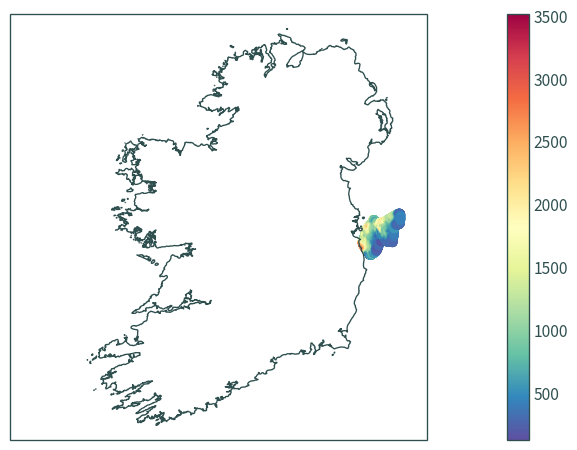

In [14]:
# plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.epsg(23029))
f_base_depth_m.plot(column="Z", legend=True, cmap="Spectral_r", ax=ax)
# ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
ie.to_crs(f_base_depth_m.crs).boundary.plot(ax=ax, color="darkslategrey", linewidth=1)
plt.axis("equal")
plt.tight_layout()
plt.show()

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


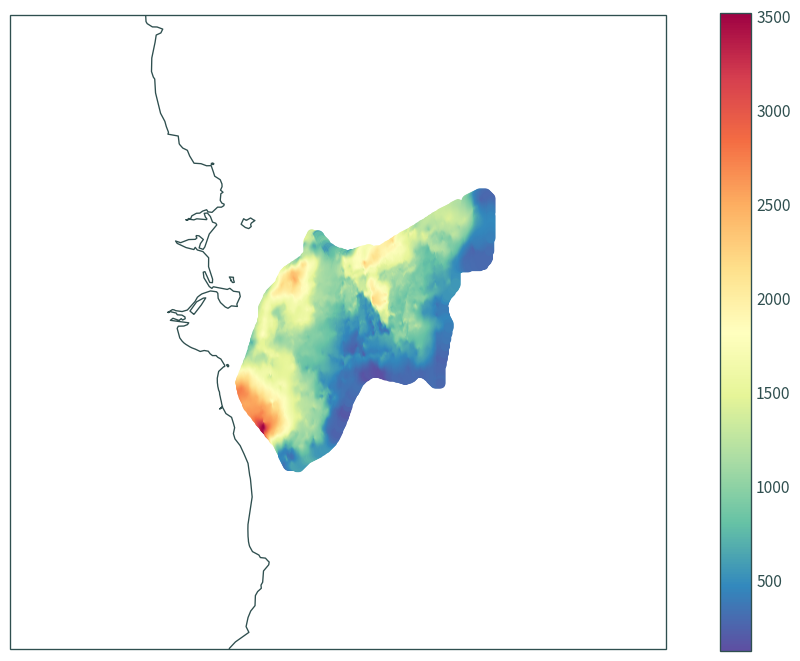

In [16]:
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.epsg(23029))
f_base_depth_m.plot(column="Z", legend=True, cmap="Spectral_r", ax=ax)
# ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
ie.to_crs(f_base_depth_m.crs).boundary.plot(ax=ax, color="darkslategrey", linewidth=1)
# plt.set_extent([687000, 742000, 5888000, 5937000])
plt.xlim(657000, 772000)
plt.ylim(5858000, 5967000)
# plt.axis("equal")
plt.tight_layout()
plt.show()

In [17]:
ds = f_base_depth_m[["X", "Y", "Z"]].set_index(["X", "Y"]).to_xarray()

In [18]:
ds

<xarray.Dataset>
Dimensions:  (X: 217, Y: 237)
Coordinates:
  * X        (X) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.396e+05 7.398e+05
  * Y        (Y) float64 5.889e+06 5.889e+06 5.89e+06 ... 5.936e+06 5.936e+06
Data variables:
    Z        (X, Y) float64 nan nan nan nan nan nan ... 273.4 nan nan nan nan

In [19]:
# ds.rio.write_crs("EPSG:23029", inplace=True)

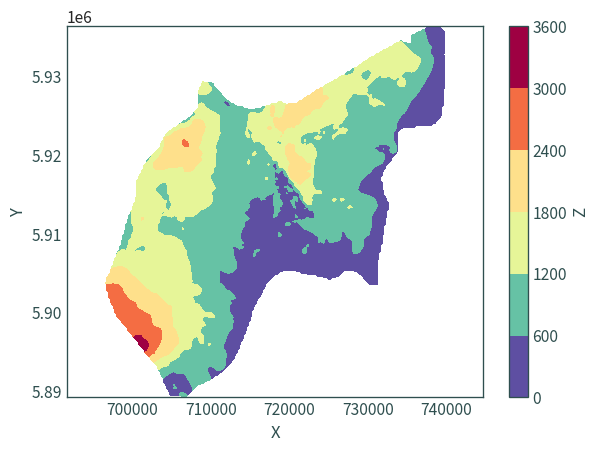

In [20]:
ax = ds["Z"].plot.contourf(x="X", y="Y", cmap="Spectral_r")
plt.axis("equal")
plt.tight_layout()
plt.show()

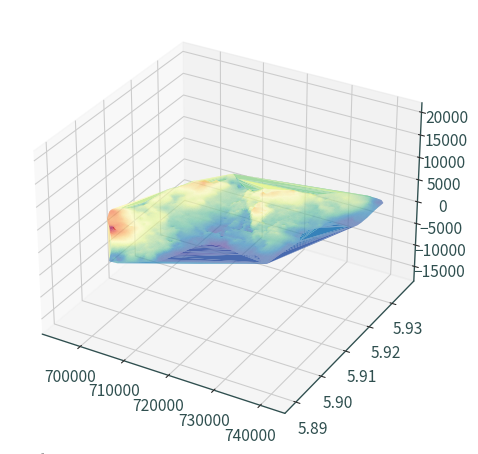

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(f_base_depth_m.X, f_base_depth_m.Y, f_base_depth_m.Z, cmap="Spectral_r")
plt.axis("equal")
plt.tight_layout()
plt.show()